## A1 - Data Curation

The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1, 2008 through September 30, 2021.

Before we begin, we must import any packages needed:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import json
import requests

### Step 1: Data Acquisition

Data was collected from two different [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API) endpoints ([Legacy Pagecount](https://wikimedia.org/api/rest_v1/#/Legacy%20data/get_metrics_legacy_pagecounts_aggregate__project___access_site___granularity___start___end_) & [Pageview](https://wikimedia.org/api/rest_v1/#/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)).

- The _Pagecount_ API contains desktop & mobile traffic data from December 2007 - July 2016
- The _Pageview_ API contains desktop, mobile web, & mobile app traffic data from July 2015 - September 2021

__Note:__ there is about 12 months of overlapping data between the APIs

The goal of this step is to collect data for all available months and save it in JSON files in the _data_ directory (1 per API call) to set us up for data processing in Step 2.

- These JSON filenames will have the following format: `apiname_accesstype_firstmonth-lastmonth.json`

Building off the [Sample API code](https://public.paws.wmcloud.org/User:Jtmorgan/data512_a1_example.ipynb) presented here and the API documentation from above, we created the below function to call each API and store the results in a JSON file.

In [2]:
def api_call(url, filename):
    call = requests.get(url, headers=headers)
    response = call.json()
    
    with open(filename, 'w') as f:
        json.dump(response, f, indent = 4)
        f.close()

The endpoint URLs & target filenames are defined below for each of the 5 API calls and are grouped by API.

__Note:__ the _Pageview_ API allows us to filter by `agent = user`, this was done to focus on organic user traffic (as opposed to traffic by web crawlers/spiders). This specification is __not__ available for the _Pagecount_ API.

In [3]:
headers = {
    'User-Agent': 'https://github.com/nriggio',
    'From': 'nriggi2@uw.edu'
}

# Legacy Pagecount API
pagecount_desktop_url = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/desktop-site/monthly/2007120100/2016073100'
pagecount_desktop_file = 'pagecounts_desktop-site_200712-202109.json'

pagecount_mobile_url = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/mobile-site/monthly/2007120100/2016073100'
pagecount_mobile_file = 'pagecounts_mobile-site_200712-202109.json'

# Pageview API
pageview_desktop_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/desktop/user/monthly/2015070100/2021100100'
pageview_desktop_file = 'pageviews_desktop_200712-202109.json'

pageview_mobileweb_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/mobile-web/user/monthly/2015070100/2021100100'
pageview_mobileweb_file = 'pageviews_mobile-web_200712-202109.json'

pageview_mobileapp_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/mobile-app/user/monthly/2015070100/2021100100'
pageview_mobileapp_file = 'pageviews_mobile-app_200712-202109.json'

Now, we call the `api_call` function for each of the 5 traffic data types. The results have been stored under the _data_ folder in this repository.

In [4]:
api_call(pagecount_desktop_url, pagecount_desktop_file)
api_call(pagecount_mobile_url, pagecount_mobile_file)
api_call(pageview_desktop_url, pageview_desktop_file)
api_call(pageview_mobileweb_url, pageview_mobileweb_file)
api_call(pageview_mobileapp_url, pageview_mobileapp_file)

### Step 2: Data Processing

The goal of this step is to perform a series of processing steps on each of the 5 JSON files to prepare them for further analysis.

__(i)__ For the data colllected from the _Pageview_ API, the monthly values for mobile web & mobile app are combined below. This results in a new dataframe representing total mobile traffic count from this API for each month.

- First, we will load & normalize the JSON files in order to work with them in a pandas dataframe. See the example output below.

In [5]:
pageview_mobileweb_df = pd.read_json('pageviews_mobile-web_200712-202109.json')
pageview_mobileweb_df = pd.json_normalize(pageview_mobileweb_df['items'])

pageview_mobileapp_df = pd.read_json('pageviews_mobile-app_200712-202109.json')
pageview_mobileapp_df = pd.json_normalize(pageview_mobileapp_df['items'])

In [6]:
pageview_mobileapp_df.head()

,project,access,agent,granularity,timestamp,views
0,en.wikipedia,mobile-app,user,monthly,2015070100,109624146
1,en.wikipedia,mobile-app,user,monthly,2015080100,109669149
2,en.wikipedia,mobile-app,user,monthly,2015090100,96221684
3,en.wikipedia,mobile-app,user,monthly,2015100100,94523777
4,en.wikipedia,mobile-app,user,monthly,2015110100,94353925


- Then, we will drop columns we no longer need and group the remaining by __timestamp__ into a singular `pageview_mobile_df`.

In [7]:
pageview_mobile_df = pd.concat([pageview_mobileweb_df, pageview_mobileapp_df])\
                        .groupby('timestamp')['views']\
                        .sum().reset_index()

In [8]:
pageview_mobile_df.head()

,timestamp,views
0,2015070100,3288755294
1,2015080100,3302333038
2,2015090100,3170203333
3,2015100100,3268499132
4,2015110100,3236601070


__(ii)__ For the second preprocessing step, we will break out the timestamp value (YYYYMMDDHH) into separate year (YYYY) & month (MM) columns and discard the remaining day & hour values.

- First, we will complete this step for the `pageview_mobile_df` since we have already been working with that data.

In [9]:
pageview_mobile_df['year'] = pageview_mobile_df['timestamp'].str[:4]
pageview_mobile_df['month'] = pageview_mobile_df['timestamp'].str[4:6]
pageview_mobile_df = pageview_mobile_df.drop(columns = ['timestamp']) 

In [10]:
pageview_mobile_df.head()

,views,year,month
0,3288755294,2015,07
1,3302333038,2015,08
2,3170203333,2015,09
3,3268499132,2015,10
4,3236601070,2015,11


- While we are doing this, we will also rename the `views` column in each dataframe based on __view type__.

In [11]:
pageview_mobile_df.rename(columns={'views':'pageview_mobile_views'}, inplace = True)

In [12]:
pageview_mobile_df.head()

,pageview_mobile_views,year,month
0,3288755294,2015,07
1,3302333038,2015,08
2,3170203333,2015,09
3,3268499132,2015,10
4,3236601070,2015,11


- Now we will repeat this process for the remaining 3 JSON files (Pageview Desktop, Pagecount Desktop, & Pagecount Mobile).

__pageview_desktop_views__

In [13]:
pageview_desktop_df = pd.read_json('pageviews_desktop_200712-202109.json')
pageview_desktop_df = pd.json_normalize(pageview_desktop_df['items'])

pageview_desktop_df = pageview_desktop_df.drop(columns = ['project', 'access', 'agent', 'granularity'])

pageview_desktop_df['year'] = pageview_desktop_df['timestamp'].str[:4]
pageview_desktop_df['month'] = pageview_desktop_df['timestamp'].str[4:6]
pageview_desktop_df = pageview_desktop_df.drop(columns = ['timestamp'])

pageview_desktop_df.rename(columns={'views':'pageview_desktop_views'}, inplace = True)

In [14]:
pageview_desktop_df.head()

,pageview_desktop_views,year,month
0,4376666686,2015,07
1,4332482183,2015,08
2,4485491704,2015,09
3,4477532755,2015,10
4,4287720220,2015,11


__pagecount_desktop_views__

In [15]:
pagecount_desktop_df = pd.read_json('pagecounts_desktop-site_200712-202109.json')
pagecount_desktop_df = pd.json_normalize(pagecount_desktop_df['items'])

pagecount_desktop_df = pagecount_desktop_df.drop(columns = ['project', 'access-site', 'granularity'])

pagecount_desktop_df['year'] = pagecount_desktop_df['timestamp'].str[:4]
pagecount_desktop_df['month'] = pagecount_desktop_df['timestamp'].str[4:6]
pagecount_desktop_df = pagecount_desktop_df.drop(columns = ['timestamp'])

pagecount_desktop_df.rename(columns={'count':'pagecount_desktop_views'}, inplace = True)

In [16]:
pagecount_desktop_df.head()

,pagecount_desktop_views,year,month
0,2998331524,2007,12
1,4930902570,2008,01
2,4818393763,2008,02
3,4955405809,2008,03
4,5159162183,2008,04


__pagecount_mobile_views__

In [17]:
pagecount_mobile_df = pd.read_json('pagecounts_mobile-site_200712-202109.json')
pagecount_mobile_df = pd.json_normalize(pagecount_mobile_df['items'])

pagecount_mobile_df = pagecount_mobile_df.drop(columns = ['project', 'access-site', 'granularity'])

pagecount_mobile_df['year'] = pagecount_mobile_df['timestamp'].str[:4]
pagecount_mobile_df['month'] = pagecount_mobile_df['timestamp'].str[4:6]
pagecount_mobile_df = pagecount_mobile_df.drop(columns = ['timestamp'])

pagecount_mobile_df.rename(columns={'count':'pagecount_mobile_views'}, inplace = True)

In [18]:
pagecount_mobile_df.head()

,pagecount_mobile_views,year,month
0,3091546685,2014,10
1,3027489668,2014,11
2,3278950021,2014,12
3,3485302091,2015,01
4,3091534479,2015,02


__(iii)__ For the final preprocessing step, we will combine all data by year & month into a single dataframe. For months with no views of a given type, we will replace any NaN values with 0. Finally, we will write this dataframe to a single CSV (`en-wikipedia_traffic_200712-202109.csv`).

- Combine the 4 dataframes with `pd.merge()`

In [19]:
df_merge_1 = pd.merge(pageview_mobile_df, pageview_desktop_df,  on = ['year', 'month'], how = 'outer')
df_merge_2 = pd.merge(df_merge_1, pagecount_mobile_df,  on = ['year', 'month'], how = 'outer')
df_merge_3 = pd.merge(df_merge_2, pagecount_desktop_df,  on = ['year', 'month'], how = 'outer')

In [20]:
pd.set_option('display.float_format', '{:.0f}'.format)

df_merge_3.head()

,pageview_mobile_views,year,month,pageview_desktop_views,pagecount_mobile_views,pagecount_desktop_views
0,3288755294,2015,07,4376666686,3254472695,5229226022
1,3302333038,2015,08,4332482183,3268487582,5035534449
2,3170203333,2015,09,4485491704,3172429827,5409631355
3,3268499132,2015,10,4477532755,3246082505,5535704471
4,3236601070,2015,11,4287720220,3218234512,5296956116


- Replace NaN with 0

In [21]:
df_final = df_merge_3.fillna(0)

In [22]:
df_final.head()

,pageview_mobile_views,year,month,pageview_desktop_views,pagecount_mobile_views,pagecount_desktop_views
0,3288755294,2015,07,4376666686,3254472695,5229226022
1,3302333038,2015,08,4332482183,3268487582,5035534449
2,3170203333,2015,09,4485491704,3172429827,5409631355
3,3268499132,2015,10,4477532755,3246082505,5535704471
4,3236601070,2015,11,4287720220,3218234512,5296956116


- Create _pagecount_all_views_ & _pageview_all_views_ columns

In [23]:
df_final['pagecount_all_views'] = df_final['pagecount_mobile_views'] + df_final['pagecount_desktop_views']
df_final['pageview_all_views'] = df_final['pageview_mobile_views'] + df_final['pageview_desktop_views']

In [24]:
df_final.head()

,pageview_mobile_views,year,month,pageview_desktop_views,pagecount_mobile_views,pagecount_desktop_views,pagecount_all_views,pageview_all_views
0,3288755294,2015,07,4376666686,3254472695,5229226022,8483698717,7665421980
1,3302333038,2015,08,4332482183,3268487582,5035534449,8304022031,7634815221
2,3170203333,2015,09,4485491704,3172429827,5409631355,8582061182,7655695037
3,3268499132,2015,10,4477532755,3246082505,5535704471,8781786976,7746031887
4,3236601070,2015,11,4287720220,3218234512,5296956116,8515190628,7524321290


- Reorder columns & sort by (year, month) ascending

In [25]:
df_final = df_final[['year', 'month', 
                     'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 
                     'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]
df_final = df_final.sort_values(['year', 'month'], ascending = [True, True]).reset_index(drop = True)

In [26]:
df_final.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2998331524,2998331524,0,0,0,0
1,2008,01,4930902570,4930902570,0,0,0,0
2,2008,02,4818393763,4818393763,0,0,0,0
3,2008,03,4955405809,4955405809,0,0,0,0
4,2008,04,5159162183,5159162183,0,0,0,0


- Write the processed dataframe to a CSV (`en-wikipedia_traffic_200712-202109.csv`)

In [27]:
final_file = 'en-wikipedia_traffic_200712-202109.csv'
df_final.to_csv(final_file, index = False)

### Step 3: Analysis

The goal of this step is to visualize the final dataset as time series graph. This plot will show desktop traffic, mobile traffic, and all traffic for each API (6 total lines).

- First, we will turn the 0's into NaN's so they don't show on our plot.

In [28]:
df_plot = df_final.replace(0, np.nan)

- Next, we will create a list of year & month pairs to plot on our x-axis.

In [29]:
x_vals = pd.to_datetime(df_plot[['year', 'month']].assign(day = 1))

- Finally, we will plot the results! (And save the output as `wiki_timeseries.png`)

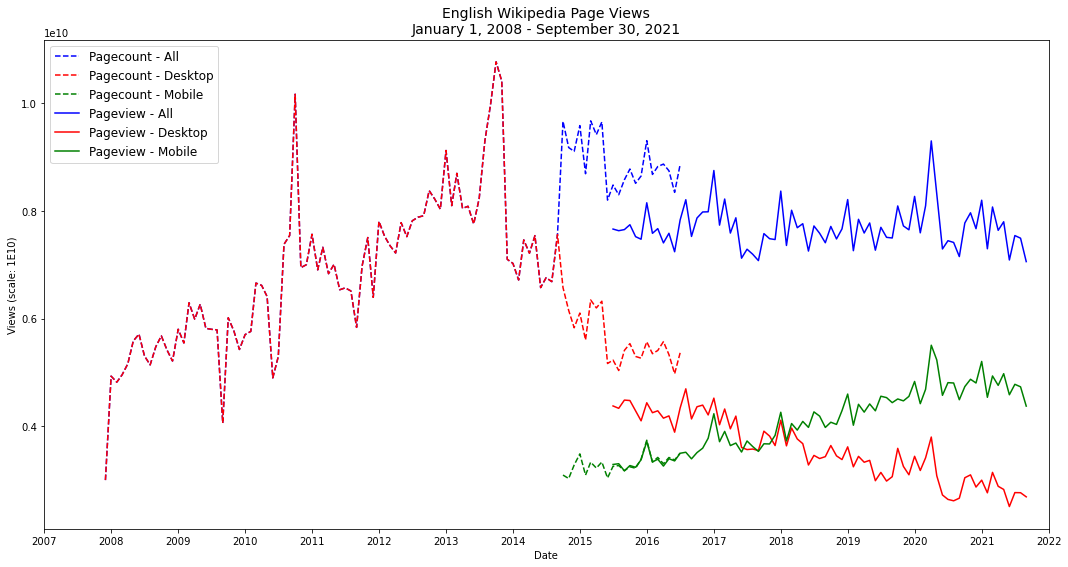

In [30]:
fig, ax = plt.subplots(figsize=(18, 9))

ax.plot(x_vals, df_plot['pagecount_all_views'], label = 'Pagecount - All', linestyle = '--', alpha = 1, color = 'blue')
ax.plot(x_vals, df_plot['pagecount_desktop_views'], label = 'Pagecount - Desktop', linestyle = '--', color = 'red')
ax.plot(x_vals, df_plot['pagecount_mobile_views'], label = 'Pagecount - Mobile', linestyle = '--', color = 'green')
ax.plot(x_vals, df_plot['pageview_all_views'], label = 'Pageview - All', linestyle = '-', color = 'blue')
ax.plot(x_vals, df_plot['pageview_desktop_views'], label = 'Pageview - Desktop', linestyle = '-', color = 'red')
ax.plot(x_vals, df_plot['pageview_mobile_views'], label = 'Pageview - Mobile', linestyle = '-', color = 'green')


ax.legend(loc = 'upper left', prop={'size': 12}) #bbox_to_anchor = (1, 1))
ax.set_ylabel('Views (scale: 1E10)')
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(dates.MonthLocator(interval = 12))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
ax.set_xlim(['2007-01-01', '2022-01-01'])

plt.title('English Wikipedia Page Views\nJanuary 1, 2008 - September 30, 2021', fontsize = 14)
plt.savefig('wiki_timeseries.png')
plt.show()

Note that until late 2014, we do not have any mobile views so the `Pagecount-All` and `Pagecount-Desktop` lines overlap exactly. Also note the scale on the y-axis (which shows views on the order of `1E10`) and the switch from dashed to solid lines representing the transition from the legacy _Pagecount_ API to the _Pageview_ API.